# Сервис аренды самокатов GoFast

**Цель исследования:** Проанализировать имеющиеся данные и проверить гипотезы относительно испольозования самокатов с подпиской и без нее.

**Ход исследования:** Данные берем из трех файлов:
- users_go.csv
- rides_go.csv
- subscriptions_go.csv

В которых содержится информация о пользователях, их поездках и подписках. На основании полученных файлов проведем исследование.

**Этапы исследования:**

- Загрузка даных;
- Предобработка данных;
- Исследовательский анализ данных;
- Объединение данных;
- Проверка гипотез.

**Описание данных:**

**Пользователи** — users_go.csv
- user_id -	уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)

**Поездки** — rides_go.csv
- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

**Подписки** — subscriptions_go.csv
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy.stats import binom
from math import sqrt
from scipy import stats as st

#### Шаг 1. Загрузка данных

##### Шаг 1.1 Считывание файлов

In [6]:
# Загружаем файлы
try:
    users = pd.read_csv('/content/users_go.csv', sep=',', skipinitialspace = True)
    rides = pd.read_csv('/content/rides_go.csv', sep=',', skipinitialspace = True)
    subscriptions = pd.read_csv('/content/subscriptions_go.csv', sep=',', skipinitialspace = True)
except:
    print('Что-то не так с файлом. Проверь файл с данными.')

##### Шаг 1.2 Общая информация

In [7]:
# Выведем первые 10 строк таблицы пользователей
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [8]:
# Выведем общую информацию по таблице пользователей
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


По общей информации о пользователях видим, что пустых строк в таблице нет.

In [9]:
# Выведем первые 10 строк таблицы поездок
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [10]:
# Выведем общую информацию по таблице поездок
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Как и в таблице пользователей, таблица поездок не имеет пустых строк, при этом дата отображена строкой. Такой тип отображения не очень удобен поэтому далее перобразуем дату в нужный нам формат.

In [11]:
# Выведем первые 10 строк таблицы подписок
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [12]:
# Выведем общую информацию по таблице подписок
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод**

Как видим все три таблицы не имеют пустых строк, при этом нужно провести преобразование даты к нужному типу.

#### Шаг 2. Предобработка данных

##### Шаг 2.1 Преобразование date

In [13]:
# Преобразуме столбец date из таблицы поездок в нужный нам формат даты
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [14]:
# Проверим формат даты
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [15]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


Как видим преобразование столбца даты прошло успешно. Данные преобразованы в формат даты.

##### Шаг 2.2 Cтолбец с номером месяца

In [16]:
# Добавим новый столбец с номеро месяца
rides['month'] = rides['date'].dt.month

In [17]:
rides.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


После выведения первых строк таблицы видим что столбец успешно добавлен.

In [18]:
# Найдем минимальную и максимальную даты
min_date = rides['date'].min()
max_date = rides['date'].max()
print('Минимальная дата:', min_date)
print('Максимальная дата:', max_date)

Минимальная дата: 2021-01-01 00:00:00
Максимальная дата: 2021-12-30 00:00:00


Видим что данные только за 12 месяцев 2021 года

##### Шаг 2.3 Пропуски и дубликаты

In [19]:
# При выводе общей информации по таблицам мы уже поняли что пропуско нет, давайте еще раз в этом убедеимся
na = users.isna().sum().sort_values()
na_perc = round(users.isna().mean()*100,2).sort_values()
display(pd.DataFrame({'Количество пропусков':na,'% пропусков':na_perc})
        .style.format('{:.2f}')
        .background_gradient('coolwarm'))

,Количество пропусков,% пропусков
user_id,0.00,0.00
name,0.00,0.00
age,0.00,0.00
city,0.00,0.00
subscription_type,0.00,0.00


In [20]:
na1 = rides.isna().sum().sort_values()
na_perc1 = round(rides.isna().mean()*100,2).sort_values()
display(pd.DataFrame({'Количество пропусков':na1,'% пропусков':na_perc1})
        .style.format('{:.2f}')
        .background_gradient('coolwarm'))

,Количество пропусков,% пропусков
user_id,0.00,0.00
distance,0.00,0.00
duration,0.00,0.00
date,0.00,0.00
month,0.00,0.00


In [21]:
na2 = subscriptions.isna().sum().sort_values()
na_perc2 = round(subscriptions.isna().mean()*100,2).sort_values()
display(pd.DataFrame({'Количество пропусков':na2,'% пропусков':na_perc2})
        .style.format('{:.2f}')
        .background_gradient('coolwarm'))

,Количество пропусков,% пропусков
subscription_type,0.00,0.00
minute_price,0.00,0.00
start_ride_price,0.00,0.00
subscription_fee,0.00,0.00


In [22]:
# Теперь проверим на явные дубликаты
print("Количество дубликатов в таблице Пользователи:", users.duplicated().sum())
print("Количество дубликатов в таблице Поездки:", rides.duplicated().sum())
print("Количество дубликатов в таблице Подписки:", subscriptions.duplicated().sum())

Количество дубликатов в таблице Пользователи: 31
Количество дубликатов в таблице Поездки: 0
Количество дубликатов в таблице Подписки: 0


In [23]:
# Выведем дубликаты для визуальной проверки
users[users.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [24]:
users.loc[users['user_id'] == 16]

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra


In [25]:
# Удаляем дубликаты и еще раз проверем их наличие
users.drop_duplicates(inplace=True)
users.duplicated().sum()

0

**Вывод:**

После проверки таблиц на пропуски видим, что их нет. При этом были обнаружены явные дубликаты в количестве 31 строки. Провели удаление данных дубликатов.

#### Шаг 3. Исследовательский анализ данных

##### Шаг 3.1 Частота встречаемости городов

In [26]:
# Сгруппируем таблицу Пользователей по городам и посчитаем количество подльзователей в каждом из них
users.groupby('city')['user_id'].count().sort_values(ascending = False)

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: user_id, dtype: int64

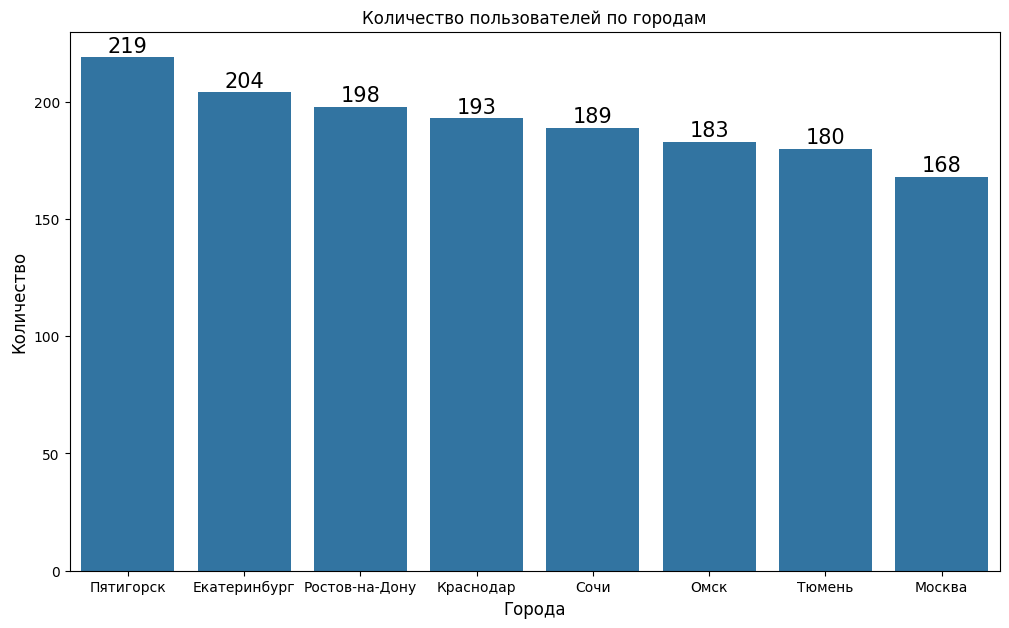

In [27]:
# Отобразим данные по городам на диаграмме.
city_am = pd.DataFrame({'city': users['city'].sort_values().unique().tolist(),
                   'count': users.groupby('city')['user_id'].count().tolist()})
city_am.sort_values('count', inplace=True, ascending = False)

plt.figure(figsize=(12, 7))

plots = sns.barplot(x=city_am['city'],
                    y=city_am['count'],
                    data=city_am)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Города", size=12)
plt.ylabel("Количество", size=12)
plt.title("Количество пользователей по городам")
plt.show()

После формирования таблицы и графика по городам видим, что больше всего пользователей в городе Пятигорск - 219 человек, а меньше всего в Москве - 168.

##### Шаг 3.2 Соотношение пользователей с подпиской и без

In [28]:
# Сгруппируем таблицу пользователей по типу подписки и добавим процент каждой категории.
subscription_am = pd.DataFrame({'subscription_type': users['subscription_type'].sort_values().unique().tolist(),
                   'count': users.groupby('subscription_type')['user_id'].count().tolist()})
subscription_am.sort_values('count', inplace=True, ascending = False)
subscription_am['percent'] = round(subscription_am['count']/users['subscription_type'].count()*100,1)
subscription_am

,subscription_type,count,percent
0,free,835,54.4
1,ultra,699,45.6


<Axes: title={'center': 'Процент пользователей по наличию подписки'}, ylabel='percent'>

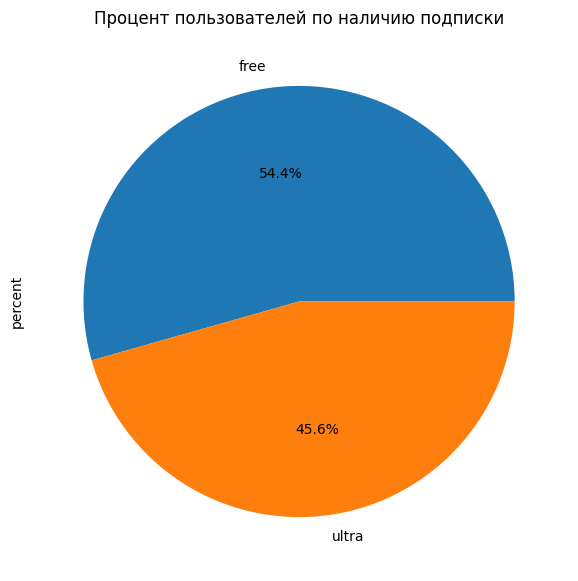

In [29]:
# Отобразим на графике
subscription_am.plot(kind='pie', y='percent', labels=subscription_am['subscription_type'], autopct='%1.1f%%',
 title='Процент пользователей по наличию подписки',
 figsize = (7, 7),
 legend=None)


**Вывод:**

Видим что соотнощение пользователей с подпиской и без нее примерно равны. При этом пользователей без подписки все таки больше, целых 54%.

##### Шаг 3.3 Возраст пользователей

In [30]:
# Первым делом посмотрим на основные показатели по столбцу
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Из полученных данным видим что среднее и медиана практически равны, следовательно значительных выбросов в столбце нет. Минимальный возраст пользователя 12 лет, максимальный - 43 года.

In [31]:
# Сгруппируем таблицу Пользователей по возрасту.
age_am = pd.DataFrame({'age': users['age'].sort_values().unique().tolist(),
                   'count': users.groupby('age')['user_id'].count().tolist()})
age_am.sort_values('count', inplace=True, ascending = False)
age_am

,age,count
13,25,145
12,24,132
14,26,131
11,23,129
15,27,119
10,22,119
16,28,112
9,21,93
8,20,71
18,30,68


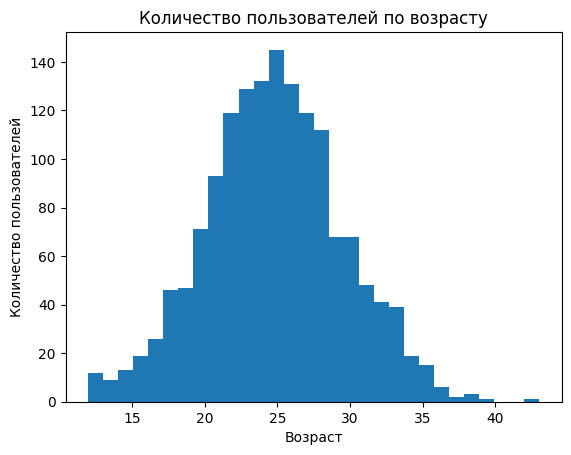

In [32]:
# Отобразим полученную таблицу на графике.
plt.hist(users['age'], bins=30)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей по возрасту')
plt.show()

**Вывод:**

Минимальный возраст пользователя 12 лет, максимальный - 43 года.

По графику видим что наибольшее количество пользователей в возрасте от 22 до 28 лет, так как в каждой и группе более 100 человек. Лидируют пользователи в возрасте 25 лет их аж 145 человек. Меньше всего пользователей в возрасте 43 года и такой пользователь всего один.

##### Шаг 3.4 Расстояние, которое пользователь преодолел за одну поездку

In [33]:
# Посмотрим на основные показатели столбца Дистанция
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

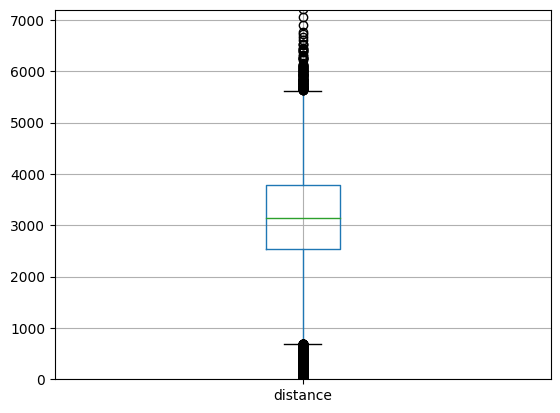

In [34]:
# А так же для наглядности построим boxplot
rides.boxplot(column = ['distance'])
plt.ylim(0,7200)
plt.show()

Медиана и среднее достатоно близки, значит выбросов не так много и можно использовать для анализа среднее значение. Минимальная дистанция меньше метра, максимальная больше 7 км.

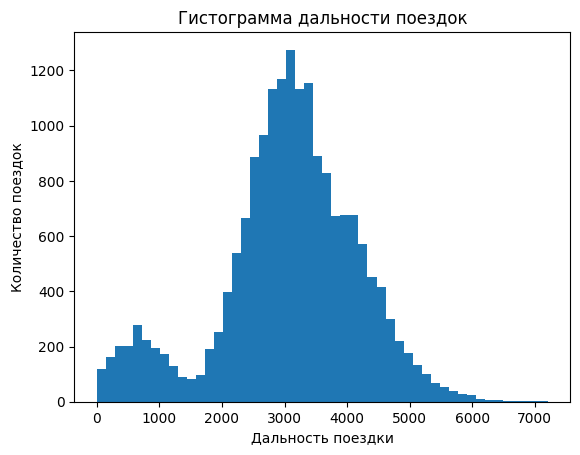

In [35]:
# Так же посмотрим на распределение поездок по дальности
plt.hist(rides['distance'], bins=50)
plt.xlabel('Дальность поездки')
plt.ylabel('Количество поездок')
plt.title('Гистограмма дальности поездок')
plt.show()

При этом мы видим что больше всего поездок с дальность от 2,5 км до 3,8 км.

In [36]:
# Сгруппируем таблицу Поездки по месяцам и найдем сумму значений пройденной дистанции.
distance_mon = pd.DataFrame({'month': rides['month'].sort_values().unique().tolist(),
                   'sum_d': rides.groupby('month')['distance'].sum().tolist()})
# Приведем полученные данные в стобце суммы к миллионам км
distance_mon['sum_d'] = round(distance_mon['sum_d']/1000000,2)
distance_mon.sort_values('sum_d', inplace=True, ascending = False)
distance_mon

,month,sum_d
0,1,4.90
4,5,4.86
5,6,4.80
11,12,4.75
6,7,4.73
2,3,4.70
8,9,4.64
7,8,4.61
3,4,4.58
9,10,4.48


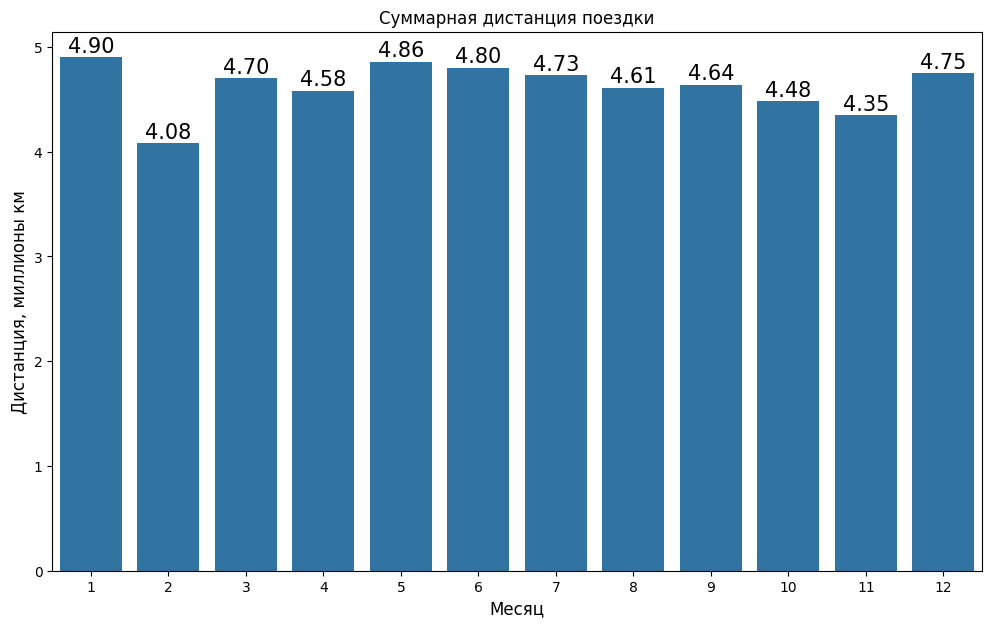

In [37]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=distance_mon['month'],
                    y=distance_mon['sum_d'],
                    data=distance_mon)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Дистанция, миллионы км", size=12)
plt.title("Суммарная дистанция поездки")
plt.show()

**Вывод:**

Минимальная дистанция меньше метра, максимальная больше 7 км. Основная часть пользователей совершает в среднем поездки от 2,5 км до 3,8 км. При этом в разбивке по месяцам средняя дистанция практически не меняется и остается на уровне 3 км. А вот если взять сумму пройденной дистанции по месяцам видим, что меньше всего дистанция была пройдена в Феврале, а больше всего в Января.

##### Шаг 3.5 Продолжительность поездок

In [38]:
# Посмотрим на основные показатели столбца Продолжительность поездки
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

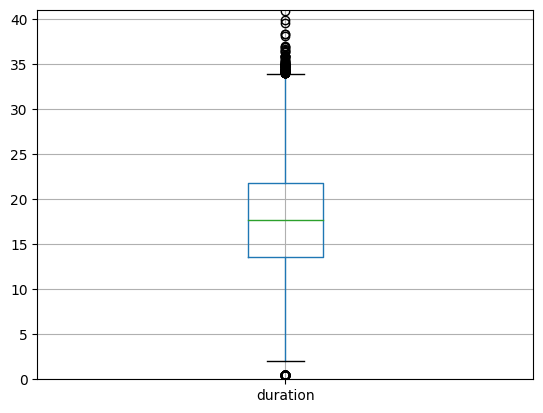

In [39]:
# Для наглядности построим boxplot
rides.boxplot(column = ['duration'])
plt.ylim(0,41)
plt.show()

Среднее время поездки составляет 18 минут. Минимальное время 30 секунд, максимальное - 41 минута.

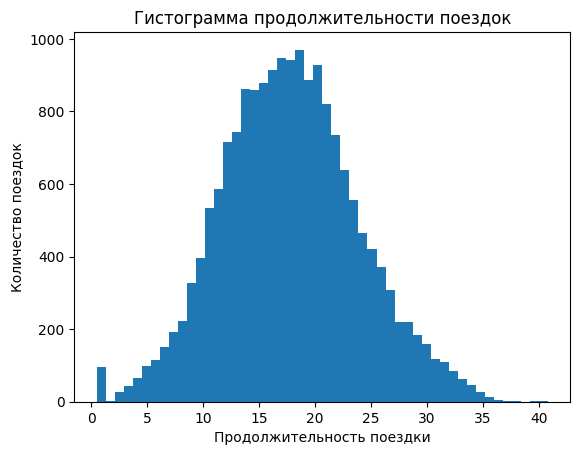

In [40]:
# Так же посмотрим на распределение поездок по длительности
plt.hist(rides['duration'], bins=50)
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.title('Гистограмма продолжительности поездок')
plt.show()

По гистограмме видно что основная часть поездок находится в диапазоне от 10 до 25 минут.

In [41]:
# Сгруппируем таблицу Поездки по месяцам и найдем сумму значений длительности поездок.
duration_mon = pd.DataFrame({'month': rides['month'].sort_values().unique().tolist(),
                   'd_sum': rides.groupby('month')['duration'].sum().tolist()})
# Приведем данные по сумму минут к часам
duration_mon['d_sum'] = round(duration_mon['d_sum']/60,0)
duration_mon.sort_values('d_sum', inplace=True, ascending = False)
duration_mon

,month,d_sum
0,1,471.0
4,5,469.0
5,6,464.0
6,7,456.0
11,12,454.0
2,3,452.0
8,9,450.0
3,4,449.0
7,8,448.0
9,10,433.0


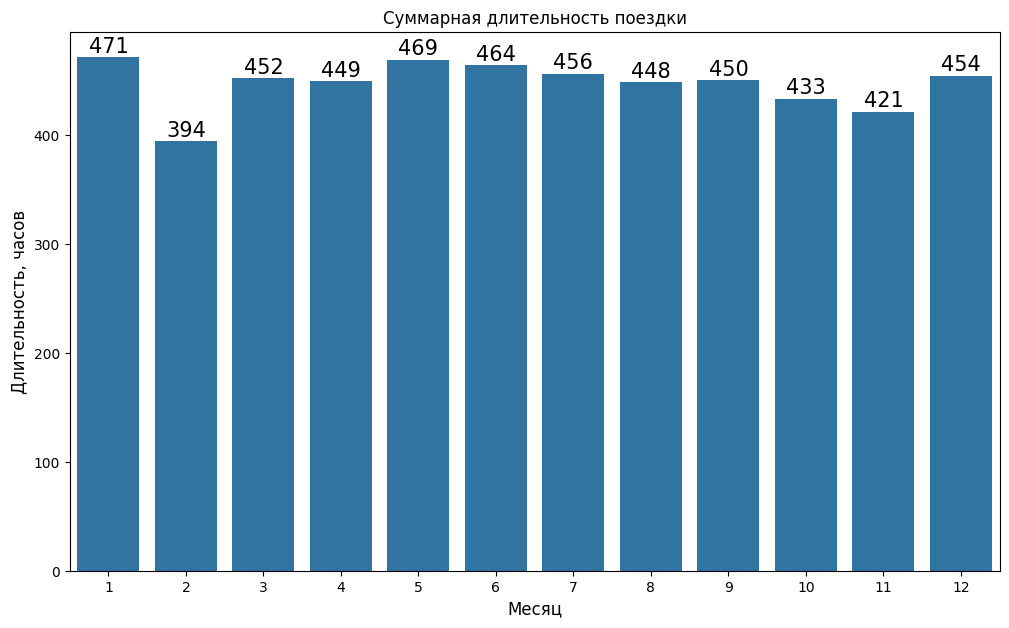

In [42]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=duration_mon['month'],
                    y=duration_mon['d_sum'],
                    data=duration_mon)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Длительность, часов", size=12)
plt.title("Суммарная длительность поездки")
plt.show()

**Вывод:**

Среднее время поездки составляет 18 минут. Минимальное время 30 секунд, максимальное - 41 минута. Основная часть поездок находится в диапазоне от 10 до 25 минут. При этом если посмотреть на сумму часов всех поездок по месяцам видим, что меньше всего длительность была в Феврале 394 часа и больше всего в Январе 471 час.


#### Шаг 4. Объединение данных

##### Шаг 4.1 Объедините данные о пользователях, поездках и подписках

In [43]:
# Начнем объединять таблицы с объединения Пользователей и Подписок, а следующим шагом уже полученную таблицу и Поездки
users_subs = pd.merge(users, subscriptions, on='subscription_type')
users_subs

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,6,0,199
1,2,Станислав,31,Омск,ultra,6,0,199
2,3,Алексей,20,Москва,ultra,6,0,199
3,4,Константин,26,Ростов-на-Дону,ultra,6,0,199
4,5,Адель,28,Омск,ultra,6,0,199
...,...,...,...,...,...,...,...,...
1529,1530,Ростислав,29,Сочи,free,8,50,0
1530,1531,Никита,25,Пятигорск,free,8,50,0
1531,1532,Алексей,26,Тюмень,free,8,50,0
1532,1533,Степан,22,Краснодар,free,8,50,0


In [44]:
# Продолжаем объединение
total_data = pd.merge(users_subs, rides, on='user_id')
total_data

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,8,50,0,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,8,50,0,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,8,50,0,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,8,50,0,2902.308661,16.674362,2021-11-27,11


**Вывод:**

После проделанных манипуляций мы получили одну сводную таблицу в которой есть вся информация о пользователях, поездках и подписках.

##### Шаг 4.2 Датафрем о пользователях с подпиской и без нее

In [45]:
# Изполучившегося датафрейма соберем два отдельных для пользователей с подпиской и без нее
with_subscription = total_data.loc[total_data['subscription_type'] == 'ultra']
with_subscription

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,6,0,199,3973.046497,24.671163,2021-08-29,8
6496,699,Оксана,22,Москва,ultra,6,0,199,3288.702563,15.892886,2021-09-12,9
6497,699,Оксана,22,Москва,ultra,6,0,199,3076.159348,14.389525,2021-09-26,9
6498,699,Оксана,22,Москва,ultra,6,0,199,4707.845501,15.839579,2021-10-17,10


In [46]:
no_subscription = total_data.loc[total_data['subscription_type'] == 'free']
no_subscription

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
6500,700,Айдар,22,Омск,free,8,50,0,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,8,50,0,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,8,50,0,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,8,50,0,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,8,50,0,3047.379435,17.427673,2021-02-14,2
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,8,50,0,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,8,50,0,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,8,50,0,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,8,50,0,2902.308661,16.674362,2021-11-27,11


Получили две таблицы. Одна с информацие о пользователях с подпиской, другая без нее.

##### Шаг 4.3 Визуализиция информацию о расстоянии и времени поездок

##### Шаг 4.3.1 Пользователи с подпиской

In [47]:
# Начнем с основных показателей
with_subscription['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Видим что показатели столбца Дистанции для пользовталей с подпиской практически не отличаются от результата по общей таблице. Медиана тут составляет 3149 метров. И разброс между медианой и средним так же небольшой, значит выброс не много.

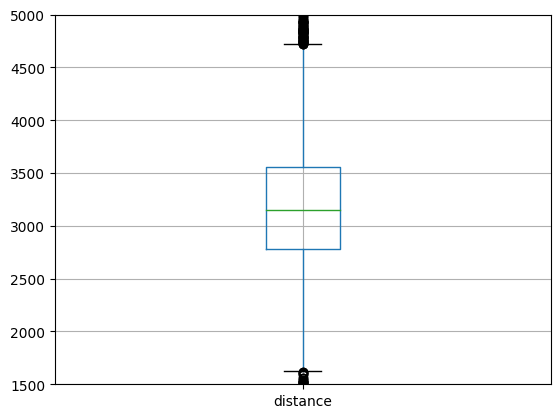

In [48]:
# Для наглядности построим boxplot
with_subscription.boxplot(column = ['distance'])
plt.ylim(1500,5000)
plt.show()

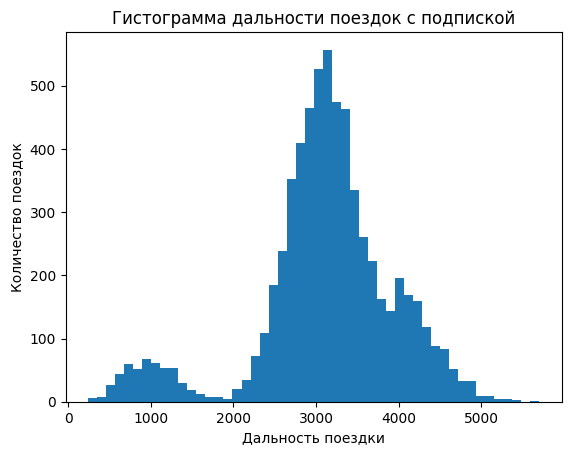

In [49]:
# Так же посмотрим на распределение поездок по дальности
plt.hist(with_subscription['distance'], bins=50)
plt.xlabel('Дальность поездки')
plt.ylabel('Количество поездок')
plt.title('Гистограмма дальности поездок с подпиской')
plt.show()

Картина похожа с графиком по всем поездкам. Больше всго поездок в идапазоне от 2,5 до 3,5 км.

In [50]:
# Сгруппируем таблицу Поездки по месяцам и найдем сумму значений пройденной дистанции.
distance_mon_with_s = pd.DataFrame({'month': with_subscription['month'].sort_values().unique().tolist(),
                   'sum_d': with_subscription.groupby('month')['distance'].sum().tolist()})
# Приведем полученные данные в стобце суммы к миллионам км
distance_mon_with_s['sum_d'] = round(distance_mon_with_s['sum_d']/1000000,2)
distance_mon_with_s.sort_values('sum_d', inplace=True, ascending = False)
distance_mon_with_s

,month,sum_d
4,5,1.87
6,7,1.81
0,1,1.80
5,6,1.76
2,3,1.75
3,4,1.71
7,8,1.69
9,10,1.66
11,12,1.64
8,9,1.59


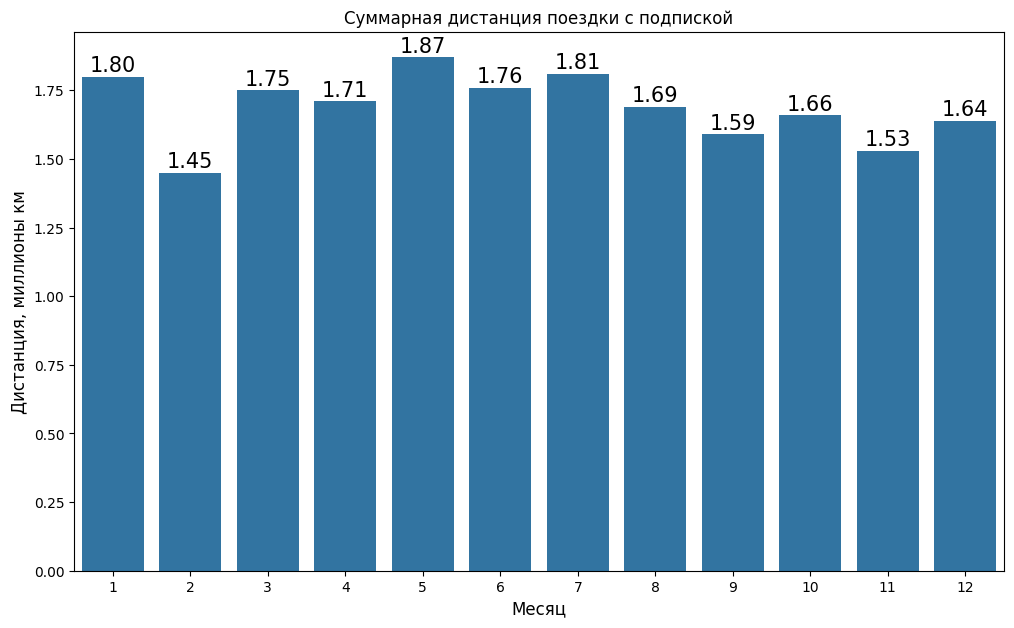

In [51]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=distance_mon_with_s['month'],
                    y=distance_mon_with_s['sum_d'],
                    data=distance_mon_with_s)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Дистанция, миллионы км", size=12)
plt.title("Суммарная дистанция поездки с подпиской")
plt.show()

По графику видим что самый смлабый месяц по суммарной длительности был все тот же Февраль - 1,45 млн км. А вот самый сильный стал Май - 1,87 млн км.

In [52]:
# Теперь посмотрим на показатели по Длительности
with_subscription['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Среднее и медиана составили 18 минут. При этом минимальная поездка почти 4 минуты, максимальная - 41 минуту

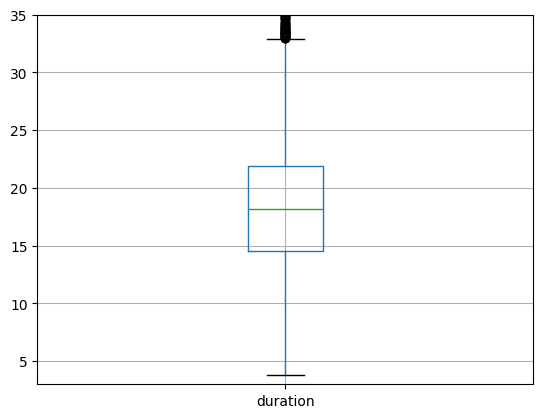

In [53]:
# Для наглядности построим boxplot
with_subscription.boxplot(column = ['duration'])
plt.ylim(3,35)
plt.show()

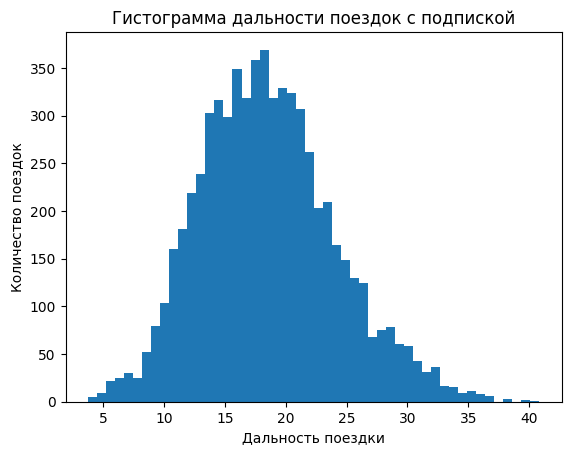

In [54]:
# Посмотрим на распределение по Длительности
plt.hist(with_subscription['duration'], bins=50)
plt.xlabel('Дальность поездки')
plt.ylabel('Количество поездок')
plt.title('Гистограмма дальности поездок с подпиской')
plt.show()

Наибольшее количество поездок в диапазоне от 14 до 22 минут.

In [55]:
# Сгруппируем таблицу Поездки по месяцам и найдем сумму значений длительности поездок.
duration_mon_with_s = pd.DataFrame({'month': with_subscription['month'].sort_values().unique().tolist(),
                   'd_sum': with_subscription.groupby('month')['duration'].sum().tolist()})
# Приведем данные по сумму минут к часам
duration_mon_with_s['d_sum'] = round(duration_mon_with_s['d_sum']/60,0)
duration_mon_with_s.sort_values('d_sum', inplace=True, ascending = False)
duration_mon_with_s

,month,d_sum
4,5,186.0
0,1,180.0
6,7,178.0
5,6,175.0
2,3,172.0
3,4,170.0
7,8,168.0
9,10,162.0
11,12,160.0
8,9,159.0


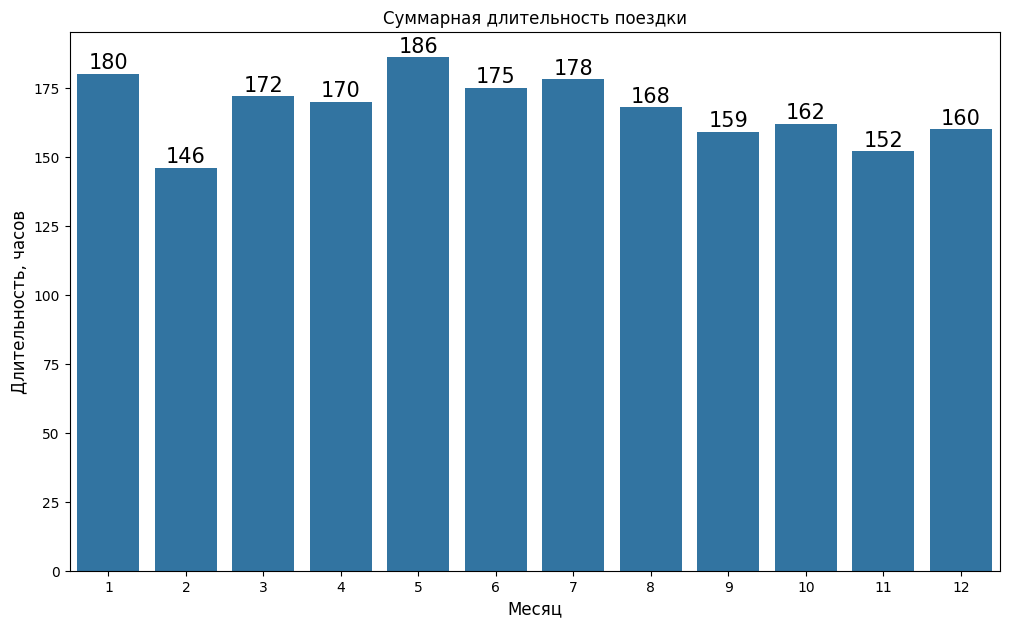

In [56]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=duration_mon_with_s['month'],
                    y=duration_mon_with_s['d_sum'],
                    data=duration_mon_with_s)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Длительность, часов", size=12)
plt.title("Суммарная длительность поездки")
plt.show()

По суммарной длительности картина похожая на график помесячного распределения суммарной дистанции. Меньше всего длительность была в Феврале всего 146 часов и больше всего в Мае - 186 часов.

##### Шаг 4.3.2 Пользователи без подписки

In [57]:
# Так же с основных показателей
no_subscription['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

Среднее дистанция 3045 метров. Минимальная поездка менее 1 метра и максимальная более 7 км.

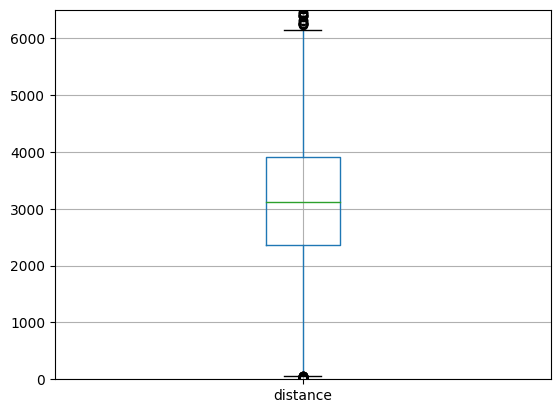

In [58]:
# Для наглядности построим boxplot
no_subscription.boxplot(column = ['distance'])
plt.ylim(0,6500)
plt.show()

Видим что разброс значений больше чем у пользователей с подпиской

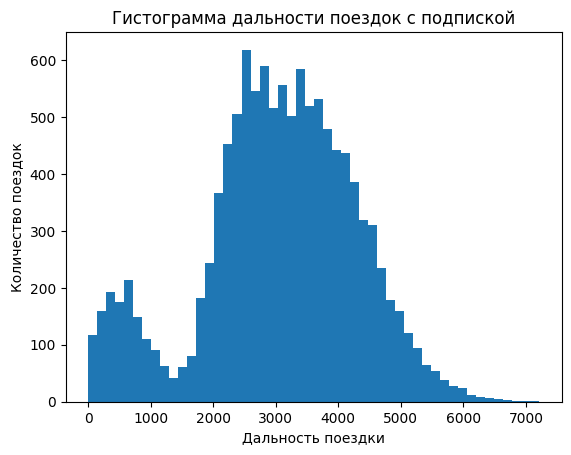

In [59]:
# Так же посмотрим на распределение поездок по дальности
plt.hist(no_subscription['distance'], bins=50)
plt.xlabel('Дальность поездки')
plt.ylabel('Количество поездок')
plt.title('Гистограмма дальности поездок с подпиской')
plt.show()

Больше всего поездок в диапазоне от 2,2 до 4 км

In [60]:
# Сгруппируем таблицу Поездки по месяцам и найдем сумму значений пройденной дистанции.
distance_mon_no_s = pd.DataFrame({'month': no_subscription['month'].sort_values().unique().tolist(),
                   'sum_d': no_subscription.groupby('month')['distance'].sum().tolist()})
# Приведем полученные данные в стобце суммы к миллионам км
distance_mon_no_s['sum_d'] = round(distance_mon_no_s['sum_d']/1000000,2)
distance_mon_no_s.sort_values('sum_d', inplace=True, ascending = False)
distance_mon_no_s

,month,sum_d
11,12,3.11
0,1,3.10
8,9,3.06
5,6,3.04
4,5,3.00
2,3,2.94
6,7,2.92
7,8,2.92
3,4,2.87
9,10,2.82


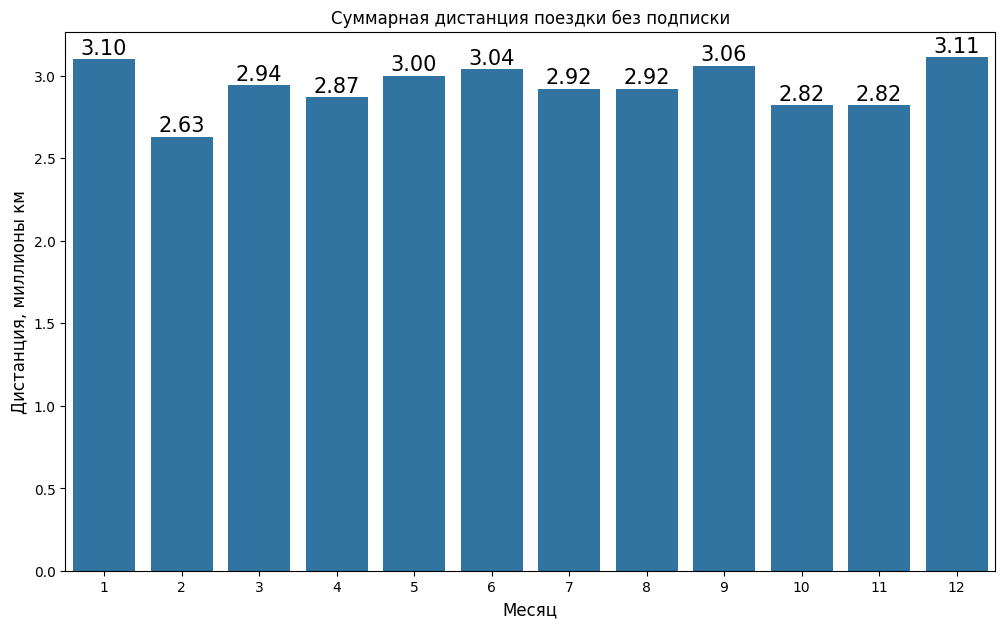

In [61]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=distance_mon_no_s['month'],
                    y=distance_mon_no_s['sum_d'],
                    data=distance_mon_no_s)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Дистанция, миллионы км", size=12)
plt.title("Суммарная дистанция поездки без подписки")
plt.show()

Согласно графика понимаем что пользователи без подписки проезжают в сумме большую дистанцию. Что логично, ведь таких пользователей больше. При этом худший месяц по общей дистанции все так же Февраль - 2,63 млн. км. А вот лучшим тут стал Декабрь 3,11 млн. км.

In [62]:
# Теперь посмотрим на показатели по Длительности
no_subscription['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

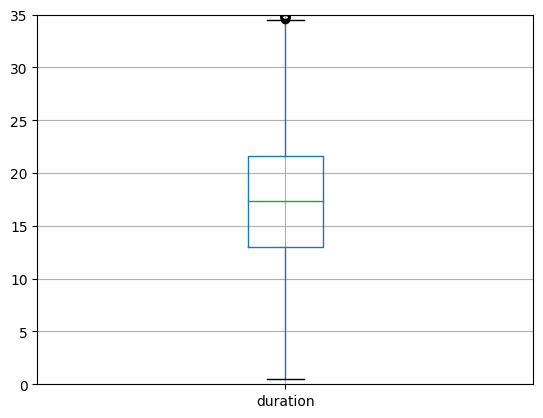

In [63]:
# Для наглядности построим boxplot
no_subscription.boxplot(column = ['duration'])
plt.ylim(0,35)
plt.show()

Среднее и медиана составили 17 минут. Что очень близко к занчению 18 минут для пользователей с подпиской. При этом минимальная поездка около 30 сек, максимальная - 35 минут.

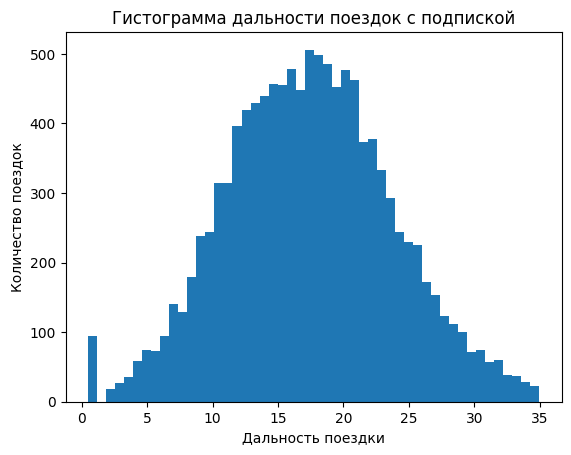

In [64]:
# Так же посмотрим на распределение поездок по дальности
plt.hist(no_subscription['duration'], bins=50)
plt.xlabel('Дальность поездки')
plt.ylabel('Количество поездок')
plt.title('Гистограмма дальности поездок с подпиской')
plt.show()

Больше всего поездок в диапазоне от 12 до 23 минут.

In [65]:
# Сгруппируем таблицу Поездки по месяцам и найдем сумму значений длительности поездок.
duration_mon_no_s = pd.DataFrame({'month': no_subscription['month'].sort_values().unique().tolist(),
                   'd_sum': no_subscription.groupby('month')['duration'].sum().tolist()})
# Приведем данные по сумму минут к часам
duration_mon_no_s['d_sum'] = round(duration_mon_no_s['d_sum']/60,0)
duration_mon_no_s.sort_values('d_sum', inplace=True, ascending = False)
duration_mon_no_s

,month,d_sum
11,12,294.0
0,1,291.0
8,9,291.0
5,6,289.0
4,5,283.0
2,3,280.0
7,8,280.0
3,4,279.0
6,7,278.0
9,10,271.0


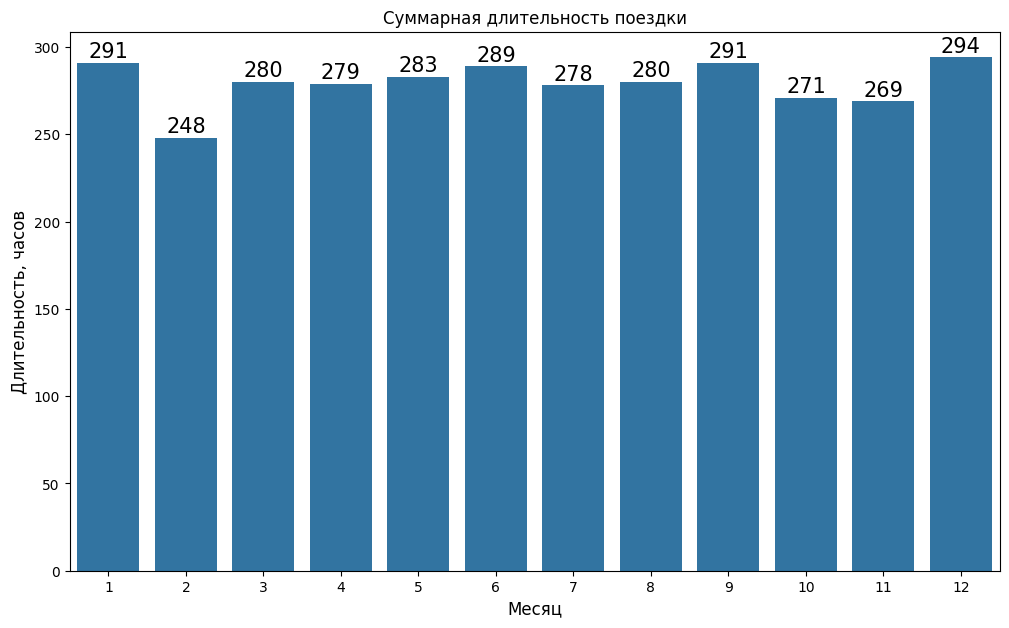

In [66]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=duration_mon_no_s['month'],
                    y=duration_mon_no_s['d_sum'],
                    data=duration_mon_no_s)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Длительность, часов", size=12)
plt.title("Суммарная длительность поездки")
plt.show()

Так же как и в длительности поездок наиболее слабый месяц Февраль - 248 часов. Самый сильный - Декабрь 294 часа.

**Вывод:**
    
Если сравнивать показатели двух групп - с подпиской и без, можно сделать выводы что в целом показатели достаточно похожи.
Средняя дистанция у пользователей с подпиской 3115 м, а у пользователей без нее 3045 м. При этом данные группы различаются по месяцам активности. Больше всего пользователи с подпиской проехали в Мае , а пользователи без нее в Декабре. Аналогичная ситуация при сравнении показателй длительности. Средняя длительность поезки пользователей с подпиской равна 18 минут, а пользоватлеей без нее 17 минут. В то же время месяца по длительности поездки совпадают с месяцами активности по дальности. При этом заметна разница в показателях как дистанции так и длительности. Показатели группы без подписки выше, что логично, так как данных пользователей больше по численности.

#### Шаг 5. Подсчёт выручки

##### Шаг 5.1 Датафрейм с агрегированными данными

In [67]:
# Для формирования датафрейма воспользуемся методом groupby().
grouped = total_data.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    num_trips=('distance', 'count'),
    total_duration=('duration', 'sum')
).reset_index()
grouped

,user_id,month,total_distance,num_trips,total_duration
0,1,1,7027.511294,2,41.416640
1,1,4,754.159807,1,6.232113
2,1,8,6723.470560,2,44.776802
3,1,10,5809.911100,2,31.578017
4,1,11,7003.499363,3,53.397424
...,...,...,...,...,...
11326,1534,6,3409.468534,2,24.812678
11327,1534,8,7622.453034,2,47.205960
11328,1534,9,4928.173852,1,22.560373
11329,1534,11,13350.015305,4,76.342174


В результате получили данные по каждому пользователюв разрезе по месяцам.

##### Шаг 5.2 Добавление столбца с помесячной выручкой

In [68]:
# Перез добавление и расчетом столбца по выручке скорректируем длительнось с помощью «потолка»:
total_data['duration'] = np.ceil(total_data['duration'])
total_data

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,26.0,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,16.0,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,7.0,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,19.0,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,27.0,2021-08-28,8
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,8,50,0,3781.098080,20.0,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,8,50,0,2840.423057,22.0,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,8,50,0,3826.185507,19.0,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,8,50,0,2902.308661,17.0,2021-11-27,11


In [69]:
# После чего добавим еще одно поле в основной датафрейм
total_data['revenue'] = total_data['start_ride_price'] * 1 + total_data['minute_price'] * total_data['duration'] + total_data['subscription_fee']
total_data

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,revenue
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,26.0,2021-01-01,1,355.0
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,16.0,2021-01-18,1,295.0
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,7.0,2021-04-20,4,241.0
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,19.0,2021-08-11,8,313.0
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,27.0,2021-08-28,8,361.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,8,50,0,3781.098080,20.0,2021-11-04,11,210.0
18064,1534,Альберт,25,Краснодар,free,8,50,0,2840.423057,22.0,2021-11-16,11,226.0
18065,1534,Альберт,25,Краснодар,free,8,50,0,3826.185507,19.0,2021-11-18,11,202.0
18066,1534,Альберт,25,Краснодар,free,8,50,0,2902.308661,17.0,2021-11-27,11,186.0


In [70]:
# И повторим манипуляцию с группировкой и добавлением выручки.
grouped_with_rev = total_data.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    num_trips=('distance', 'count'),
    total_duration=('duration', 'sum'),
    total_revenue=('revenue', 'sum')
).reset_index()
grouped_with_rev

,user_id,month,total_distance,num_trips,total_duration,total_revenue
0,1,1,7027.511294,2,42.0,650.0
1,1,4,754.159807,1,7.0,241.0
2,1,8,6723.470560,2,46.0,674.0
3,1,10,5809.911100,2,32.0,590.0
4,1,11,7003.499363,3,56.0,933.0
...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,308.0
11327,1534,8,7622.453034,2,48.0,484.0
11328,1534,9,4928.173852,1,23.0,234.0
11329,1534,11,13350.015305,4,78.0,824.0


In [71]:
# Первый шаг уже сделан.
total_data.head(5)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month,revenue
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,26.0,2021-01-01,1,355.0
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,16.0,2021-01-18,1,295.0
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,7.0,2021-04-20,4,241.0
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,19.0,2021-08-11,8,313.0
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,27.0,2021-08-28,8,361.0


In [72]:
# Второй шаг. Для формирования датафрейма воспользуемся методом groupby().
grouped_t = total_data.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    num_trips=('distance', 'count'),
    total_duration=('duration', 'sum'),
).reset_index()
grouped_t

,user_id,month,total_distance,num_trips,total_duration
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,46.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,56.0
...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0
11327,1534,8,7622.453034,2,48.0
11328,1534,9,4928.173852,1,23.0
11329,1534,11,13350.015305,4,78.0


In [73]:
# Чтобы посчитать выручку нам потребуются данные из таблицы подписок, поэтому добавим их в агрегированную таблицу
grouped_subs = pd.merge(grouped_t, users_subs[['user_id',
                                            'subscription_type',
                                            'minute_price',
                                            'start_ride_price',
                                            'subscription_fee']], on='user_id', how='inner')
grouped_subs

,user_id,month,total_distance,num_trips,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,2,42.0,ultra,6,0,199
1,1,4,754.159807,1,7.0,ultra,6,0,199
2,1,8,6723.470560,2,46.0,ultra,6,0,199
3,1,10,5809.911100,2,32.0,ultra,6,0,199
4,1,11,7003.499363,3,56.0,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,free,8,50,0
11327,1534,8,7622.453034,2,48.0,free,8,50,0
11328,1534,9,4928.173852,1,23.0,free,8,50,0
11329,1534,11,13350.015305,4,78.0,free,8,50,0


In [74]:
grouped_subs['revenue'] = grouped_subs['start_ride_price'] * grouped_subs['num_trips'] + \
                          grouped_subs['minute_price'] * grouped_subs['total_duration'] + \
                          grouped_subs['subscription_fee']
grouped_subs

,user_id,month,total_distance,num_trips,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.511294,2,42.0,ultra,6,0,199,451.0
1,1,4,754.159807,1,7.0,ultra,6,0,199,241.0
2,1,8,6723.470560,2,46.0,ultra,6,0,199,475.0
3,1,10,5809.911100,2,32.0,ultra,6,0,199,391.0
4,1,11,7003.499363,3,56.0,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,free,8,50,0,308.0
11327,1534,8,7622.453034,2,48.0,free,8,50,0,484.0
11328,1534,9,4928.173852,1,23.0,free,8,50,0,234.0
11329,1534,11,13350.015305,4,78.0,free,8,50,0,824.0


В результате мы получили нужный нам датафрейм.

Так как нам потребуеюся изучить отдельные группы - с подпиской и без нее. Сделаем сразу два дата фрейма.


In [75]:
# Пользователи с подпиской
grouped_with_sub = grouped_subs.loc[grouped_subs['subscription_type'] == 'ultra']
grouped_with_sub

,user_id,month,total_distance,num_trips,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.511294,2,42.0,ultra,6,0,199,451.0
1,1,4,754.159807,1,7.0,ultra,6,0,199,241.0
2,1,8,6723.470560,2,46.0,ultra,6,0,199,475.0
3,1,10,5809.911100,2,32.0,ultra,6,0,199,391.0
4,1,11,7003.499363,3,56.0,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
4528,699,6,4072.797406,1,17.0,ultra,6,0,199,301.0
4529,699,8,7018.324143,2,45.0,ultra,6,0,199,469.0
4530,699,9,6364.861911,2,31.0,ultra,6,0,199,385.0
4531,699,10,4707.845501,1,16.0,ultra,6,0,199,295.0


Аналогично соберем таблицу для пользователей без подписки

In [76]:
grouped_no_sub = grouped_subs.loc[grouped_subs['subscription_type'] == 'free']
grouped_no_sub

,user_id,month,total_distance,num_trips,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
4533,700,1,2515.690719,1,15.0,free,8,50,0,170.0
4534,700,2,13446.659764,5,89.0,free,8,50,0,962.0
4535,700,3,3798.334905,1,19.0,free,8,50,0,202.0
4536,700,4,2984.551206,1,16.0,free,8,50,0,178.0
4537,700,6,5927.650988,2,29.0,free,8,50,0,332.0
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,2,26.0,free,8,50,0,308.0
11327,1534,8,7622.453034,2,48.0,free,8,50,0,484.0
11328,1534,9,4928.173852,1,23.0,free,8,50,0,234.0
11329,1534,11,13350.015305,4,78.0,free,8,50,0,824.0


В результате имеем две таблицы для дальнейшего анализа.

#### Шаг 6. Проверка гипотез

##### Шаг 6.1 Тратят ли пользователи с подпиской больше времени на поездки?

In [77]:
# Выведем общие данные по длительности поездки для пользователей с подпиской
grouped_with_sub['total_duration'].describe()

count    4533.000000
mean       27.298698
std        14.710456
min         4.000000
25%        17.000000
50%        23.000000
75%        35.000000
max       126.000000
Name: total_duration, dtype: float64

In [78]:
# Для пользователей без подписки
grouped_no_sub['total_duration'].describe()

count    6798.000000
mean       30.444690
std        17.876362
min         1.000000
25%        18.000000
50%        26.000000
75%        40.000000
max       143.000000
Name: total_duration, dtype: float64

Видим что среднее значение для пользователей без подписки выше и составляет 30 минут.

In [79]:
# Сгруппируем таблицу Поездки по месяцам и найдем сумму значений длительности поездок для пользователей с подпиской.
duration_mon_ws = pd.DataFrame({'month': grouped_with_sub['month'].sort_values().unique().tolist(),
                   'd_sum': grouped_with_sub.groupby('month')['total_duration'].sum().tolist()})
# Приведем данные по сумму минут к часам
duration_mon_ws['d_sum'] = round(duration_mon_ws['d_sum']/60,0)
duration_mon_ws.sort_values('d_sum', inplace=True, ascending = False)
duration_mon_ws

,month,d_sum
4,5,191.0
0,1,185.0
6,7,183.0
5,6,180.0
2,3,177.0
3,4,175.0
7,8,173.0
9,10,166.0
11,12,164.0
8,9,163.0


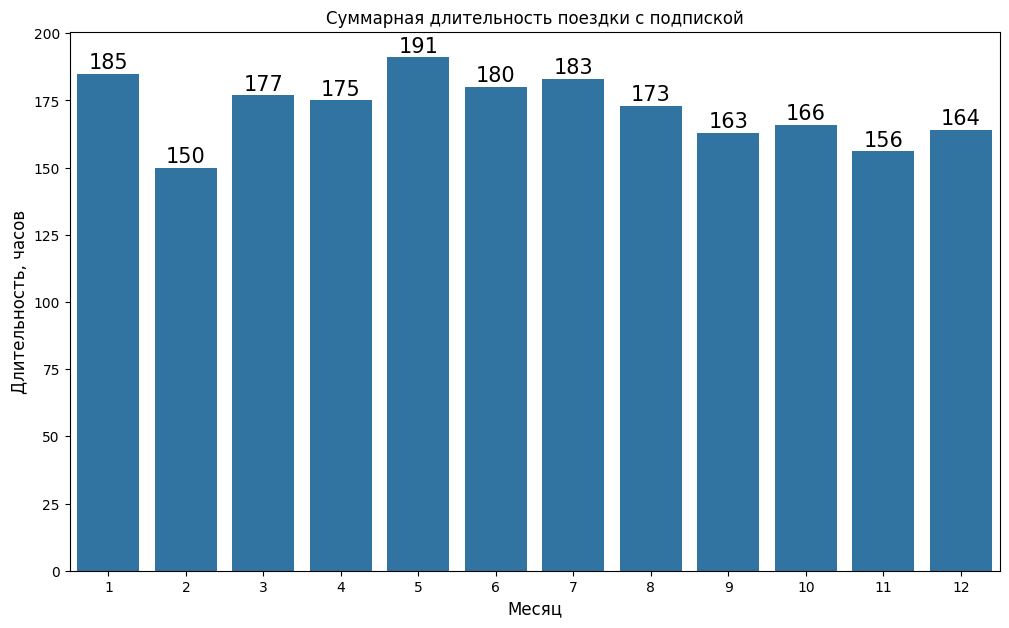

In [80]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=duration_mon_ws['month'],
                    y=duration_mon_ws['d_sum'],
                    data=duration_mon_ws)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Длительность, часов", size=12)
plt.title("Суммарная длительность поездки с подпиской")
plt.show()

In [81]:
# Сгруппируем таблицу Поездки по месяцам и найдем сумму значений длительности поездок для пользователей без подпиской.
duration_mon_ns = pd.DataFrame({'month': grouped_no_sub['month'].sort_values().unique().tolist(),
                   'd_sum': grouped_no_sub.groupby('month')['total_duration'].sum().tolist()})
# Приведем данные по сумму минут к часам
duration_mon_ns['d_sum'] = round(duration_mon_ns['d_sum']/60,0)
duration_mon_ns.sort_values('d_sum', inplace=True, ascending = False)
duration_mon_ns

,month,d_sum
11,12,302.0
0,1,300.0
8,9,299.0
5,6,297.0
4,5,291.0
2,3,288.0
7,8,288.0
3,4,287.0
6,7,286.0
9,10,279.0


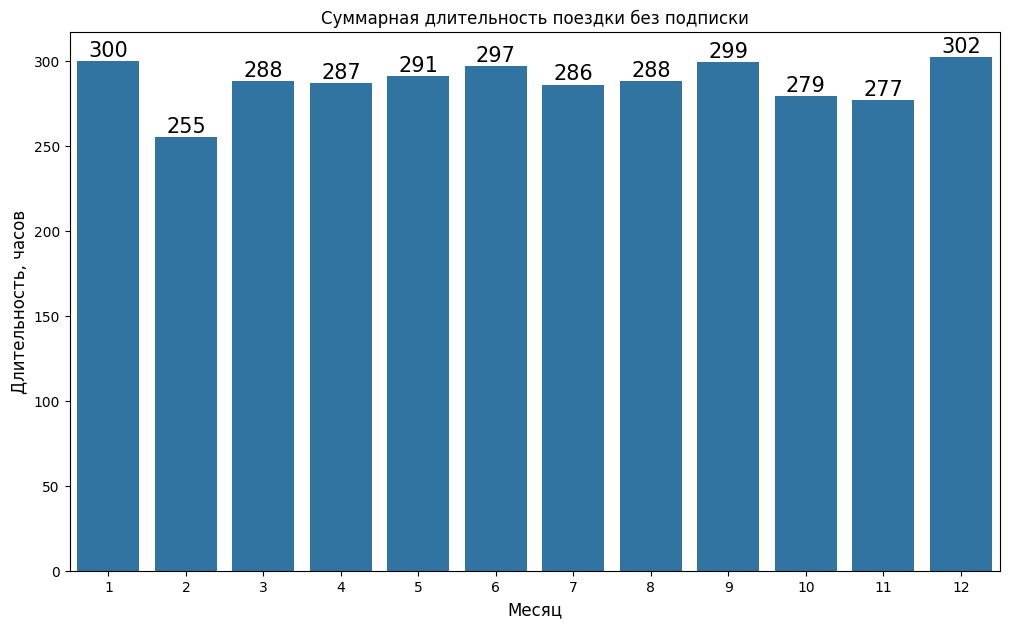

In [82]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=duration_mon_ns['month'],
                    y=duration_mon_ns['d_sum'],
                    data=duration_mon_ns)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Длительность, часов", size=12)
plt.title("Суммарная длительность поездки без подписки")
plt.show()

А вот если сравнивать помесячное распределение суммарной длительности поездки то видим что для пользоваталей с подпиской наиболее популярные месяцы были Январь и Май. А для пользователей без подписки Январь и Декабрь. При этом суммарная длительно пользователей без подписки выше. Что так же обусловлено большим кодичеством пользователей данной группы.


Видим что среднее время поезди выше у пользователей без подписки и составляет 30 минут. При этом в разделе 4.3.1 и 4.3.2 мы видели другую картину. Длительность поездки пользователей с подпиской была выше чем у пользоватлей без подписки. И расчет там проводился на основании каждой сессии. Поэтому проведем дополнительный анализ с помощью метода st.ttest_ind на основании каждой сессии.

При этом у нас будет две гипотезы:
- Нулевая гипотеза: средние длительности поездок пользователей из двух групп равны.
- Альтернативная гипотеза: среднее значение длительности поездки пользователей с подпиской больше, чем среднее значение длительности поездки пользователей без подписки

In [83]:
# Задаём уровень значимости
alpha = 0.05

# Проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
# Так как выборки разного размера добавим значение equal_var=False
results = st.ttest_ind(with_subscription['duration'],
                       no_subscription['duration'],
                       equal_var=False,
                       alternative='greater')

print(f'p-value: {results.pvalue}')

# Проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


**Вывод:**

В результате проведенного исследования мы пришли к выводу, что верна альтенативная гипотеза. То есть среднее значение длительности поездки пользователей с подпиской больше чем без подписки. Следовательно наша гипотеза подтведилась.

##### Шаг 6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката?

In [84]:
# Выведем общие данные по дальности поездки для пользователей с подпиской
grouped_with_sub['total_distance'].describe()

count     4533.000000
mean      4467.327382
std       2353.168174
min        244.210438
25%       2981.762521
50%       3572.518224
75%       5883.378452
max      20009.704886
Name: total_distance, dtype: float64

In [85]:
# Для пользователей без подписки
grouped_no_sub['total_distance'].describe()

count     6798.000000
mean      5182.449164
std       3198.989334
min          2.570787
25%       2952.361137
50%       4324.635714
75%       6861.657086
max      23429.487786
Name: total_distance, dtype: float64

Из общих данных видим что средняя дальность поездки значительно выше для обоих групп. При этом так же заметна разница между средним значением и медианой, что говорит о большом разбрасе данных. Поэтому дальше будем использовать медиану.

In [86]:
# Сгруппируем таблицу Поездки по месяцам и найдем медиану пройденной дистанции с подпиской.
distance_mon_ws = pd.DataFrame({'month': grouped_with_sub['month'].sort_values().unique().tolist(),
                   'sum_d': grouped_with_sub.groupby('month')['total_distance'].median().tolist()})
# Округлим данные
distance_mon_ws['sum_d'] = round(distance_mon_ws['sum_d'],0)
distance_mon_ws.sort_values('sum_d', inplace=True, ascending = False)
distance_mon_ws

,month,sum_d
0,1,3796.0
6,7,3671.0
8,9,3648.0
11,12,3648.0
3,4,3596.0
4,5,3563.0
10,11,3559.0
5,6,3545.0
7,8,3539.0
2,3,3525.0


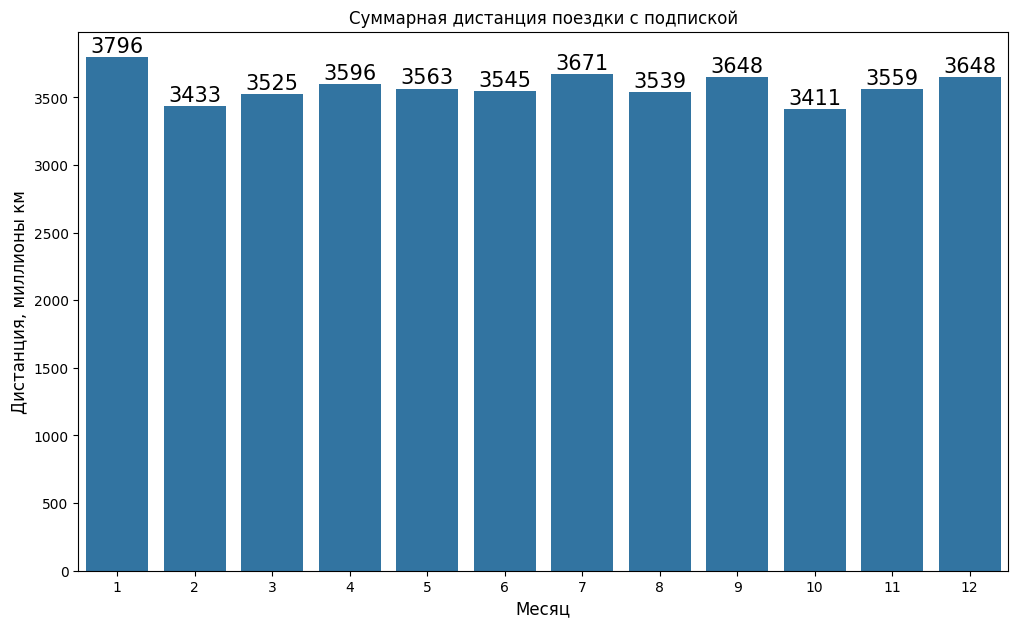

In [87]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=distance_mon_ws['month'],
                    y=distance_mon_ws['sum_d'],
                    data=distance_mon_ws)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Дистанция, миллионы км", size=12)
plt.title("Суммарная дистанция поездки с подпиской")
plt.show()

In [88]:
# Сгруппируем таблицу Поездки по месяцам и найдем медиану пройденной дистанции без подписки.
distance_mon_ns = pd.DataFrame({'month': grouped_no_sub['month'].sort_values().unique().tolist(),
                   'sum_d': grouped_no_sub.groupby('month')['total_distance'].mean().tolist()})
# Округлим данные
distance_mon_ns['sum_d'] = round(distance_mon_ns['sum_d'],0)
distance_mon_ns.sort_values('sum_d', inplace=True, ascending = False)
distance_mon_ns

,month,sum_d
2,3,5295.0
8,9,5295.0
11,12,5279.0
4,5,5229.0
6,7,5202.0
3,4,5190.0
7,8,5176.0
0,1,5167.0
5,6,5159.0
9,10,5130.0


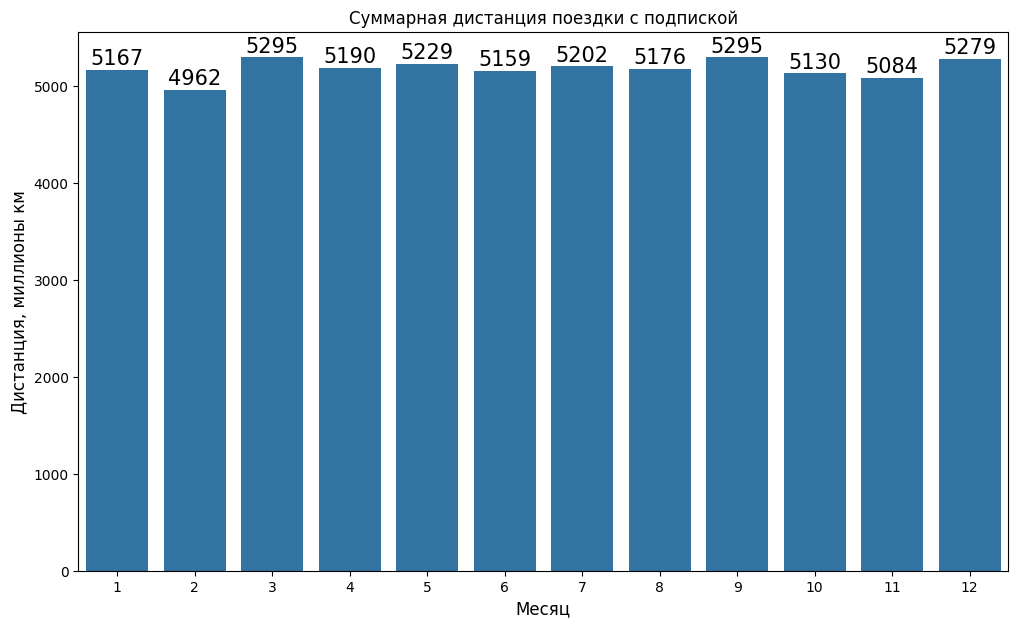

In [89]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=distance_mon_ns['month'],
                    y=distance_mon_ns['sum_d'],
                    data=distance_mon_ns)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Дистанция, миллионы км", size=12)
plt.title("Суммарная дистанция поездки с подпиской")
plt.show()

После проведенного анализа видим что у нас результаты исследования отличаются. В данном разделе мы смотрели информацию с разбивкой по месяцам пользователям. А в разделах 4.3.1 и 4.3.2 с разбивкой по каждой сессии. Поэтому для проверки проведем дополнительное исследование с помощью все того же метода st.ttest_1samp на основании каждой сессии.

При этом у нас будет две гипотезы:

- Нулевая гипотеза: средняя дальность поездки не менее 3130 метров.
- Альтернативная гипотеза: средняя дальность поездки менее 3130 метров.

In [90]:
# Дальность поездки не менее 3130
interested_value = 3130

# Уровень статистической значимости
alpha = 0.05

results = st.ttest_1samp(
    with_subscription['distance'],
    interested_value,
      alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: дистанция менее 3130')
else:
    print('Не получилось отвергнуть нулевую гипотезу: дистанция не менее 3130')

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу: дистанция не менее 3130


In [ ]:
# Дальность поездки не менее 3130
interested_value = 3130

# Уровень статистической значимости
alpha = 0.05

results = st.ttest_1samp(
    no_subscription['distance'],
    interested_value,
      alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: дистанция менее 3130')
else:
    print('Не получилось отвергнуть нулевую гипотезу: дистанция не менее 3130')

p-значение: 1.609514695200983e-13
Отвергаем нулевую гипотезу: дистанция менее 3130


**Вывод:**

После проведения дополнительного исследования для каждой из групп с учетом каждой сессии видим, что для пользователей с подпиской дистанция составляет не менее 3130 метров, а вот для второй группы дистанция меньше. Следовательно можно сделать вывод что гипотеза так же подтвеждается.

Так же проверим второй вариант:

- Нулевая гипотеза: средняя дальность поездки не менее 3130 метров.
- Альтернативная гипотеза: средняя дальность поездки более 3130 метров.

In [91]:
# Дальность поездки не менее 3130
interested_value = 3130

# Уровень статистической значимости
alpha = 0.05

results = st.ttest_1samp(
    with_subscription['distance'],
    interested_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: дистанция более 3130')
else:
    print('Не получилось отвергнуть нулевую гипотезу: дистанция не менее 3130')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу: дистанция не менее 3130


In [92]:
# Дальность поездки не менее 3130
interested_value = 3130

# Уровень статистической значимости
alpha = 0.05

results = st.ttest_1samp(
    no_subscription['distance'],
    interested_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: дистанция более 3130')
else:
    print('Не получилось отвергнуть нулевую гипотезу: дистанция не менее 3130')

p-значение: 0.999999999999839
Не получилось отвергнуть нулевую гипотезу: дистанция не менее 3130


В случае если мы проверям дистанцию на большую чем 3130 получаем в обоих случаях что дистанция не менее 3130 метров. То есть ни одна из версий про большую дистанцию не подтвердилась. Следовательно дистанция по износу в 3130 метров достаточная.

##### Шаг 6.3 Помесячная выручка от пользователей с подпиской по месяцам выше

In [93]:
# Выведем общие данные по выручке для пользователей с подпиской
grouped_with_sub['revenue'].describe()

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: revenue, dtype: float64

In [94]:
# Для пользователей без подписки
grouped_no_sub['revenue'].describe()

count    6798.000000
mean      328.641365
std       183.868330
min        58.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: revenue, dtype: float64

Видим что среднее значение для пользователей с подпиской выше чем для пользователей без нее. Так же заметна разница между медианой и средним. Поэтому более точные расчеты будут при использовании медианы.

In [95]:
# Сгруппируем таблицу Поездки по месяцам и найдем медиану выручки для пользователей с подписки.
revenue_mon_ws = pd.DataFrame({'month': grouped_with_sub['month'].sort_values().unique().tolist(),
                   'sum_d': grouped_with_sub.groupby('month')['revenue'].median().tolist()})
# Округлим данные
revenue_mon_ws['sum_d'] = round(distance_mon_ws['sum_d'],0)
revenue_mon_ws.sort_values('sum_d', inplace=True, ascending = False)
revenue_mon_ws

,month,sum_d
0,1,3796.0
6,7,3671.0
8,9,3648.0
11,12,3648.0
3,4,3596.0
4,5,3563.0
10,11,3559.0
5,6,3545.0
7,8,3539.0
2,3,3525.0


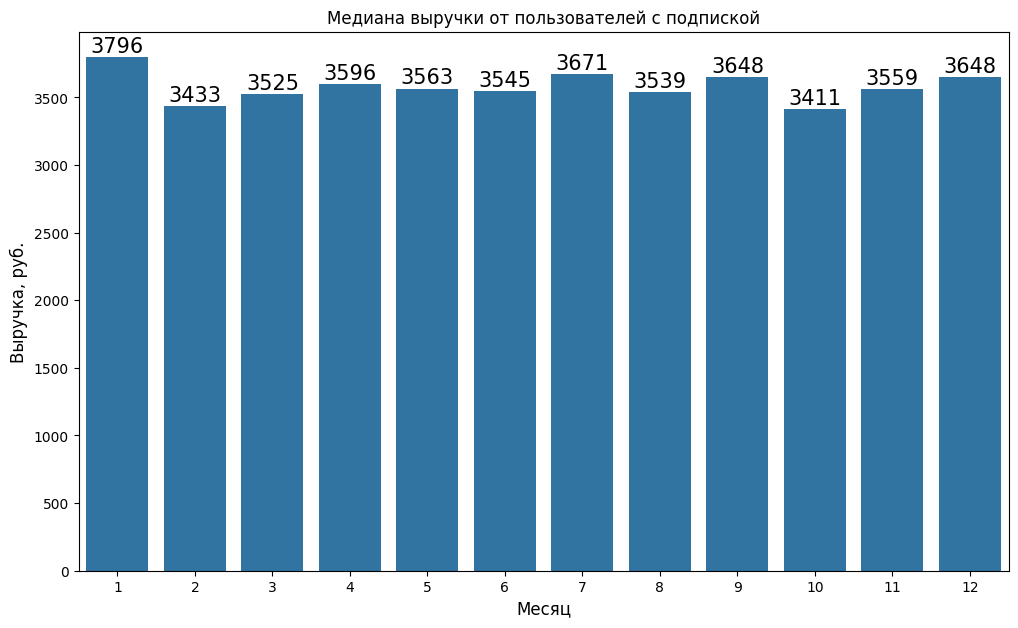

In [96]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=revenue_mon_ws['month'],
                    y=revenue_mon_ws['sum_d'],
                    data=revenue_mon_ws)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Выручка, руб.", size=12)
plt.title("Медиана выручки от пользователей с подпиской")
plt.show()

In [97]:
# Сгруппируем таблицу Поездки по месяцам и найдем медиану выручки для пользователей без подписки.
revenue_mon_ns = pd.DataFrame({'month': grouped_no_sub['month'].sort_values().unique().tolist(),
                   'sum_d': grouped_no_sub.groupby('month')['revenue'].median().tolist()})
# Округлим данные
revenue_mon_ns['sum_d'] = round(revenue_mon_ns['sum_d'],0)
revenue_mon_ns.sort_values('sum_d', inplace=True, ascending = False)
revenue_mon_ns

,month,sum_d
8,9,298.0
9,10,292.0
3,4,284.0
2,3,276.0
5,6,274.0
7,8,274.0
10,11,270.0
0,1,266.0
4,5,266.0
11,12,266.0


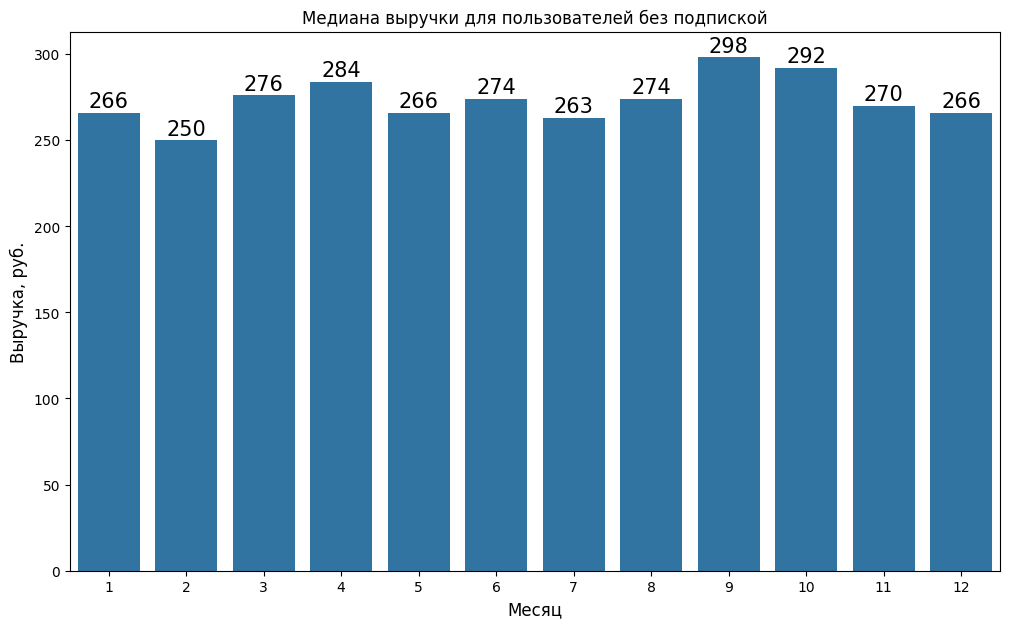

In [98]:
# Отобразим полученную таблицу на графике.
plt.figure(figsize=(12, 7))

plots = sns.barplot(x=revenue_mon_ns['month'],
                    y=revenue_mon_ns['sum_d'],
                    data=revenue_mon_ns)


for bar in plots.patches:

  plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')


plt.xlabel("Месяц", size=12)
plt.ylabel("Выручка, руб.", size=12)
plt.title("Медиана выручки для пользователей без подпиской")
plt.show()

Видим что значения средней вручки по группе с подпиской выше чем по группе без нее, 449 рублей и 329 рублей соответственно. При этом если посмотреть в разрезе месяцов медиана выручки от пользователей с подпиской была выше и не опускалась ниже 416 рублей. При этом медиана пользователей без подписки не поднималась выше 298 рублей.

Так же для дополнительной проверки проведем еще одно исследование с использованием метода st.ttest_ind.

Наши гипотезы:
- Нулевая гипотеза: средние помесячные выручки от пользователей из двух групп равны.
- Альтернативная гипотеза: среднее помесячной выручки от пользователей с подпиской больше, чем среднее помесячной выручки от пользователей без подписки

In [99]:
# Задаём уровень значимости
alpha = 0.05

# Проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
# Так как выборки разного размера добавим значение equal_var=False
results = st.ttest_ind(grouped_with_sub['revenue'],
                       grouped_no_sub['revenue'],
                       equal_var=False,
                       alternative='greater')

print(f'p-value: {results.pvalue}')

# Проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


**Вывод:**
После проведения дополнительного исследования мы так же получили подтверждение что выручка от пользователей с подпиской выше чем от пользователей без подписки.

##### Шаг 6.4 Какой тест вам понадобился бы для проверки этой гипотезы?

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ:**

Так как у нас две зависимые (парные) выборки нам понадобится тест scipy.stats.ttest_rel

#### Шаг 8. Выводы

Шаг 1.

Как видим все три таблицы не имеют пустых строк.

Шаг 2.

Провести преобразование даты к нужному типу. После проверки таблиц на пропуски видим, что их нет. При этом были обнаружены явные дубликаты в количестве 31 строки. Провели удаление данных дубликатов.

Шаг 3.

- После формирования таблицы и графика по городам видим, что больше всего пользователей в городе Пятигорск - 219 человек, а меньше всего в Москве - 168.
- Видим что соотнощение пользователей с подпиской и без нее примерно равны. При этом пользователей без подписки все таки больше, целых 54%.
- Минимальный возраст пользователя 12 лет, максимальный - 43 года. По графику видим что наибольшее количество пользователей в возрасте от 22 до 28 лет, так как в каждой и группе более 100 человек. Лидируют пользователи в возрасте 25 лет их аж 145 человек. Меньше всего пользователей в возрасте 43 года и такой пользователь всего один.
- Минимальная дистанция меньше метра, максимальная больше 7 км. Основная часть пользователей совершает в среднем поездки от 2,5 км до 3,8 км. При этом в разбивке по месяцам средняя дистанция практически не меняется и остается на уровне 3 км. А вот если взять сумму пройденной дистанции по месяцам видим, что меньше всего дистанция была пройдена в Феврале, а больше всего в Января.
- Среднее время поездки составляет 18 минут. Минимальное время 30 секунд, максимальное - 41 минута. Основная часть поездок находится в диапазоне от 10 до 25 минут. При этом если посмотреть на сумму часов всех поездок по месяцам видим, что меньше всего длительность была в Феврале 394 часа и больше всего в Январе 471 час.

Шаг 4.

Провели объединение данных о пользователях, поездках и подписках.
Если сравнивать показатели двух групп - с подпиской и без, можно сделать выводы что в целом показатели достаточно похожи. Средняя дистанция у пользователей с подпиской 3115 м, а у пользователей без нее 3045 м. При этом данные группы различаются по месяцам активности. Больше всего пользователи с подпиской проехали в Мае , а пользователи без нее в Декабре. Аналогичная ситуация при сравнении показателй длительности. Средняя длительность поезки пользователей с подпиской равна 18 минут, а пользоватлеей без нее 17 минут. В то же время месяца по длительности поездки совпадают с месяцами активности по дальности. При этом заметна разница в показателях как дистанции так и длительности. Показатели группы без подписки выше, что логично, так как данных пользователей больше по численности.

Шаг 5.

Провели подсчет выручки с разивкой помесячно и по каждому пользователю.

Шаг 6.

1) Важно понять, тратят ли пользователи с подпиской больше времени на поездки?

Проверили анализ средних показателей длительности поездки по итерациям и получили подтверждение гипотезы. То есть пользователи с подпиской в среднем тратят 19 минут на покздку, при этом пользователи без подписки всего 17 минут. После чего был проведен анализ данных на основании агрегированной таблицы по месяцам, где получили противопроложный вывод. И как следствие для проверки провели еще один тест с импользованием метода метода st.ttest_ind. Который показал, что верна альтенативная гипотеза. То есть среднее значение длительности поездки пользователей с подпиской больше чем без подписки. А следовательно гипотеза верна.

2) Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.

Для проверки гипотезы так же провели несколько исследований. Первый анализ проводился на основании итерации, то есть одной поездки. В результате получили что средняя дальность покздки для пользователей с подпиской составляет 3115 м, а без подписки 3045. При этом во стором исследовании использовали агрегированные данные по месяцам и результат получился противоположный - 4467 метров и 5182 метра соответственно. Третье исследование проводислось с импользованием метода st.ttest_1samp. В результате получили информацию, что для пользователей с подпиской средняя дистанция составляет не менее 3130 метров, а вот для пользователей без подписки дистанция меньше 3130 метров. То есть гипотезу так же можно считать верной.

3) Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

В данном случае проводилась два вида анализа. В обоих использовали агрегированные данные по месяцам. В первом использовали среднее значение по столбцу выручки, в резульате для пользователей с подпиской среднее значение составило 449 рублей, а для пользоватлей без нее 328 рублей. Так же для проверки результате использовали второй подход на основе метода st.ttest_ind. В результате получили подтверждение альтернативной гипотезы о том что выручка от пользователей с подпиской выше чем выручка от пользователей без нее. Как следствие гипотеза так же верна.